In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
image_folder = '/content/drive/MyDrive/data/images'
mask_folder = '/content/drive/MyDrive/data/labels'


In [4]:
!pip install tifffile


In [5]:
class FloodDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(image_dir))  # ensure matching order
        self.mask_names = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Load 12-band image as numpy array
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

        # Load image (expecting .npy or .tif or multi-band format)
        image = np.load(img_path) if img_path.endswith('.npy') else np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))

        # Normalize image to [0, 1]
        image = image.astype(np.float32) / 255.0
        mask = (mask > 0).astype(np.float32)  # Binary mask

        # Convert to tensors
        image = torch.from_numpy(image).permute(2, 0, 1)  # shape: [12, 128, 128]
        mask = torch.from_numpy(mask).unsqueeze(0)        # shape: [1, 128, 128]

        return image, mask


In [7]:
import tifffile

class FloodDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

        # ✅ Use tifffile to read 12-band image
        image = tifffile.imread(img_path).astype(np.float32) / 255.0  # shape: [128, 128, 12]

        # Transpose to [C, H, W] as PyTorch expects
        image = np.transpose(image, (2, 0, 1))  # [12, 128, 128]

        # Load mask using PIL (works fine for 1-band masks)
        mask = np.array(Image.open(mask_path)).astype(np.float32)
        mask = (mask > 0).astype(np.float32)

        # Convert to tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask).unsqueeze(0)  # [1, 128, 128]

        return image, mask


In [6]:
dataset = FloodDataset(image_folder, mask_folder)

# Split into train and val (optional)
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

Image shape: torch.Size([12, 128, 128])
Mask shape: torch.Size([1, 128, 128])


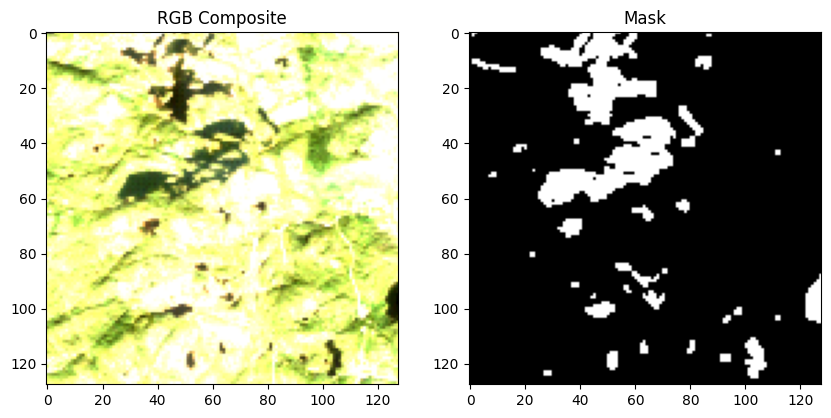

In [8]:
dataset = FloodDataset(image_folder, mask_folder)

# 🔍 Visualize one sample
import matplotlib.pyplot as plt

# Choose a sample index (e.g. 0)
img, mask = dataset[0]

print("Image shape:", img.shape)  # Should be [12, 128, 128]
print("Mask shape:", mask.shape)  # Should be [1, 128, 128]

# Convert to numpy for plotting
img_np = img.numpy()
mask_np = mask.squeeze().numpy()

# Select 3 bands to display as RGB (e.g., bands 4, 3, 2 for RGB-like view)
# Adjust band indices as needed for your data
r = img_np[3]  # Band 4
g = img_np[2]  # Band 3
b = img_np[1]  # Band 2

rgb_image = np.stack([r, g, b], axis=-1)
rgb_image = np.clip(rgb_image, 0, 1)  # Just in case of overflow

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(rgb_image)
axs[0].set_title("RGB Composite")
axs[1].imshow(mask_np, cmap='gray')
axs[1].set_title("Mask")
plt.show()


In [9]:
from torch.utils.data import DataLoader, random_split

# Split into 80% training and 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)

        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))

        u1 = self.up1(d4)
        u1 = self.conv1(torch.cat([u1, d3], dim=1))
        u2 = self.up2(u1)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))
        u3 = self.up3(u2)
        u3 = self.conv3(torch.cat([u3, d1], dim=1))

        return torch.sigmoid(self.final(u3))


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=12, out_channels=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [12]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)


In [13]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            loss = criterion(preds, masks)
            running_loss += loss.item()
    return running_loss / len(loader)


In [14]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}  |  Val Loss: {val_loss:.4f}")


KeyboardInterrupt: 